In [ ]:
# Load the dataset from Google Drive
import pandas as pd

# The URL points to the CSV file containing the data
train_with_ECC_set = 'https://drive.google.com/uc?id=1v84VB3DMrA0DI3ZwJHcT4iF-hXuyu2sq'
TECC_csv = pd.read_csv(train_with_ECC_set)

# Display the first few rows to confirm it loaded correctly
# TECC_csv.head()

In [ ]:
import numpy as np
import pandas as pd


r0 = 1.2  # fm

# Rename σ cal → ECC if not already done
if 'ECC' not in TECC_csv.columns:
    TECC_csv = TECC_csv.rename(columns={'σ cal': 'ECC'})

# Add Physics-informed features (re-calculated to ensure they are present)
TECC_csv['Z1Z2_over_Ecm'] = (TECC_csv['Z1'] * TECC_csv['Z2']) / TECC_csv['E c.m.']
TECC_csv["Vb"] = (TECC_csv["Z1"] * TECC_csv["Z2"] * 1.44) / (
    r0 * (TECC_csv["A1"]**(1/3) + TECC_csv["A2"]**(1/3))
)
TECC_csv["alpha_mass"] = (TECC_csv["A1"] - TECC_csv["A2"]) / (TECC_csv["A1"] + TECC_csv["A2"])
TECC_csv["NZ_ratio_P"] = TECC_csv["N1"] / TECC_csv["Z1"]
TECC_csv["NZ_ratio_T"] = TECC_csv["N2"] / TECC_csv["Z2"]
TECC_csv["NZ_ratio_compound"] = (TECC_csv["N1"] + TECC_csv["N2"]) / (TECC_csv["Z1"] + TECC_csv["Z2"])
TECC_csv["mu"] = (TECC_csv["A1"] * TECC_csv["A2"]) / (TECC_csv["A1"] + TECC_csv["A2"])

# Distance from magic numbers
magic_Z = [2, 8, 20, 28, 50, 82]
magic_N = [2, 8, 20, 28, 50, 82, 126]

TECC_csv["magic_dist_Z1"] = TECC_csv["Z1"].apply(lambda z: min(abs(z - m) for m in magic_Z))
TECC_csv["magic_dist_N1"] = TECC_csv["N1"].apply(lambda n: min(abs(n - m) for m in magic_N))
TECC_csv["magic_dist_Z2"] = TECC_csv["Z2"].apply(lambda z: min(abs(z - m) for m in magic_Z))
TECC_csv["magic_dist_N2"] = TECC_csv["N2"].apply(lambda n: min(abs(n - m) for m in magic_N))

# Ensure Q_fusion is present
if 'Q_fusion' not in TECC_csv.columns:
    TECC_csv['Q_fusion'] = TECC_csv['Compound_Nucleus_Binding_Energy'] - (
        TECC_csv['Projectile_Binding_Energy'] + TECC_csv['Target_Binding_Energy']
    )

# Add PCN features if not already present
pcn_feature_names = ['ZCN', 'ACN', 'E_star', 'zeta', 'VB_bass', 'chi_eff', 'PCN_empirical']
if not all(feature in TECC_csv.columns for feature in pcn_feature_names):

    def engineer_advanced_pcn_features(df):
        df_copy = df.copy()

        # Rename columns for clarity
        rename_map = {'Z1': 'Zp', 'A1': 'Ap', 'Z2': 'Zt', 'A2': 'At', 'E c.m.': 'Ec_m'}
        df_copy.rename(columns={k: v for k, v in rename_map.items() if k in df_copy.columns}, inplace=True)

        # Column references
        zp_col = 'Zp' if 'Zp' in df_copy.columns else 'Z1'
        zt_col = 'Zt' if 'Zt' in df_copy.columns else 'Z2'
        ap_col = 'Ap' if 'Ap' in df_copy.columns else 'A1'
        at_col = 'At' if 'At' in df_copy.columns else 'A2'
        ecm_col = 'Ec_m' if 'Ec_m' in df_copy.columns else 'E c.m.'

        # Compound nucleus
        df_copy['ZCN'] = df_copy[zp_col] + df_copy[zt_col]
        df_copy['ACN'] = df_copy[ap_col] + df_copy[at_col]

        # Excitation energy
        if 'Q ( 2 n )' in df_copy.columns:
            df_copy['E_star'] = df_copy[ecm_col] + df_copy['Q ( 2 n )']
        else:
            df_copy['E_star'] = df_copy[ecm_col]

        # Reduced mass number and zeta
        df_copy['reduced_mass_number'] = (df_copy[ap_col] * df_copy[at_col]) / (df_copy[ap_col] + df_copy[at_col])
        df_copy['zeta'] = (df_copy[zp_col] * df_copy[zt_col]) / np.sqrt(df_copy['reduced_mass_number'])

        # Fusion Barrier (Bass model)
        R_bass = 1.07 * (np.power(df_copy[ap_col], 1/3) + np.power(df_copy[at_col], 1/3))
        df_copy['VB_bass'] = (1.44 * df_copy[zp_col] * df_copy[zt_col]) / (R_bass + 2.7)

        # Effective fissility
        A_cn, Z_cn = df_copy['ACN'], df_copy['ZCN']
        mass_asym = (df_copy[at_col] - df_copy[ap_col]) / (df_copy[at_col] + df_copy[ap_col])
        fissility_num = Z_cn**2 / A_cn
        fissility_den = 50.88 * (1 - 1.78 * ((A_cn - 2*Z_cn)/A_cn)**2)
        fissility = fissility_num / fissility_den
        df_copy['chi_eff'] = np.where((1 - mass_asym**2) != 0, fissility / (1 - mass_asym**2), fissility)

        # Empirical PCN
        B_const = 21.196
        exponent_numerator = (df_copy['E_star'] - df_copy['VB_bass']) * df_copy['chi_eff']
        exponent_denominator = B_const * (df_copy['zeta'] ** 0.02)
        with np.errstate(divide='ignore', invalid='ignore'):
            df_copy['PCN_empirical'] = 3.58 * np.exp(exponent_numerator / exponent_denominator)
            df_copy['PCN_empirical'] = df_copy['PCN_empirical'].replace([np.inf, -np.inf], np.nan).fillna(0)

        return df_copy[['ZCN', 'ACN', 'E_star', 'zeta', 'VB_bass', 'chi_eff', 'PCN_empirical']]

    pcn_features_df = engineer_advanced_pcn_features(TECC_csv)
    TECC_csv = pd.concat([TECC_csv, pcn_features_df], axis=1)

# -----------------------------
# Feature sets
# -----------------------------
basic_features = ['E c.m.', 'Z1', 'N1', 'A1', 'Z2', 'N2', 'A2', 'Z3', 'N3', 'A3']
basic_ecc_features = basic_features + ['ECC']

physics_informed_reduced_features = ['Z1Z2_over_Ecm', 'ECC', 'PCN_empirical','Q ( 2 n )']
physics_features = [col for col in physics_informed_reduced_features if col in TECC_csv.columns]

# Target
y = TECC_csv['σ']

# -----------------------------
# Manual reaction-based train/test split - SWAPPED LOGIC(we can try different reactions to check)
# -----------------------------
test_reactions_list = [
    "16 O + 70 Ge","16 O + 144 Sm","19 F + 208 Pb",
    '16 O + 144 Nd','30 Si + 30 Si'
    "12 C + 238 U",'28 Si + 164 Er','32 S + 89 Y','40 Ca + 50 Ti'
]

test_idx = TECC_csv[TECC_csv["Reaction"].isin(test_reactions_list)].index
train_idx = TECC_csv[~TECC_csv["Reaction"].isin(test_reactions_list)].index


# Split features and target
X_train_basic = TECC_csv.loc[train_idx, basic_features]
X_test_basic = TECC_csv.loc[test_idx, basic_features]
y_train_basic = y.loc[train_idx]
y_test_basic = y.loc[test_idx]

X_train_basic_ecc = TECC_csv.loc[train_idx, basic_ecc_features]
X_test_basic_ecc = TECC_csv.loc[test_idx, basic_ecc_features]
y_train_basic_ecc = y.loc[train_idx]
y_test_basic_ecc = y.loc[test_idx]

X_train_phys = TECC_csv.loc[train_idx, physics_features]
X_test_phys = TECC_csv.loc[test_idx, physics_features]
y_train_phys = y.loc[train_idx]
y_test_phys = y.loc[test_idx]

# -----------------------------
# Summary
# -----------------------------
print("Manual reaction-based train/test split done (swapped logic).")
print("Basic feature shape:", X_train_basic.shape, X_test_basic.shape)
print("Basic+ECC feature shape:", X_train_basic_ecc.shape, X_test_basic_ecc.shape)
print("REDUCED Physics-informed feature shape:", X_train_phys.shape, X_test_phys.shape)
print("Number of train reactions:", TECC_csv["Reaction"].nunique() - len(test_reactions_list))
print("Number of test reactions:", len(test_reactions_list))

Manual reaction-based train/test split done (swapped logic).
Basic feature shape: (3371, 10) (165, 10)
Basic+ECC feature shape: (3371, 11) (165, 11)
REDUCED Physics-informed feature shape: (3371, 4) (165, 4)
Number of train reactions: 205
Number of test reactions: 8


In [ ]:
def run_model_conference(
    model_class, model_params,
    X_train_basic, y_train_basic,
    X_train_basic_ecc, y_train_basic_ecc,
    X_train_phys, y_train_phys,
    X_test_basic, X_test_basic_ecc, X_test_phys,
    TECC_csv, test_idx,
    model_label="", run_shap=False,
    top_features=8, use_ensemble=True,
    show_grid=True
):
    """
    Trains models on three feature sets (Basic, Basic+ECC, Physics-informed),
    generates reaction-wise prediction plots for publication, optional SHAP analysis,
    and returns evaluation metrics and test predictions.
    """
    import os
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import shap
    from sklearn.metrics import mean_squared_error, r2_score
    from sklearn.linear_model import LinearRegression
    from IPython.display import display
    import re

    # --------------------------
    # sanitize numeric data
    # --------------------------
    def sanitize_df(df):
        df_safe = df.copy()
        df_safe.columns = [c.replace(' ', '_').replace('(', '').replace(')', '') for c in df_safe.columns]
        return df_safe.apply(pd.to_numeric, errors='coerce').fillna(0)

    def evaluate_model_default(y_true, y_pred, name="model"):
        y_true = np.array(y_true, dtype=float)
        y_pred = np.array(y_pred, dtype=float)
        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        y_true, y_pred = y_true[mask], y_pred[mask]
        rmse = np.sqrt(mean_squared_error(y_true, y_pred)) if len(y_true) > 0 else np.nan
        r2 = r2_score(y_true, y_pred) if len(y_true) > 1 else np.nan
        positive_mask = (y_true > 0) & (y_pred > 0)
        log_mae_val = np.mean(np.abs(np.log10(y_pred[positive_mask]) - np.log10(y_true[positive_mask]))) \
            if positive_mask.any() else np.nan
        return {"RMSE": float(rmse), "R2": float(r2), "log10-MAE": float(log_mae_val)}

    evaluate_fn = globals().get("evaluate_model", evaluate_model_default)

    # --------------------------
    # Sanitize all datasets
    # --------------------------
    X_train_basic_safe     = sanitize_df(X_train_basic)
    X_train_basic_ecc_safe = sanitize_df(X_train_basic_ecc)
    X_train_phys_safe      = sanitize_df(X_train_phys)
    X_test_basic_safe      = sanitize_df(X_test_basic)
    X_test_basic_ecc_safe  = sanitize_df(X_test_basic_ecc)
    X_test_phys_safe       = sanitize_df(X_test_phys)
    y_train_basic_safe     = np.array(pd.to_numeric(y_train_basic, errors='coerce').fillna(0))
    y_train_basic_ecc_safe = np.array(pd.to_numeric(y_train_basic_ecc, errors='coerce').fillna(0))
    y_train_phys_safe      = np.array(pd.to_numeric(y_train_phys, errors='coerce').fillna(0))

    # --------------------------
    # Train models
    # --------------------------
    model_basic     = model_class(**model_params).fit(X_train_basic_safe, y_train_basic_safe)
    model_basic_ecc = model_class(**model_params).fit(X_train_basic_ecc_safe, y_train_basic_ecc_safe)
    model_phys      = model_class(**model_params).fit(X_train_phys_safe, y_train_phys_safe)

    # --------------------------
    # Predictions
    # --------------------------
    y_pred_basic      = model_basic.predict(X_test_basic_safe)
    y_pred_basic_ecc  = model_basic_ecc.predict(X_test_basic_ecc_safe)
    y_pred_phys       = model_phys.predict(X_test_phys_safe)

    test_df = TECC_csv.loc[test_idx].copy()
    test_df['σ_pred_basic']     = y_pred_basic
    test_df['σ_pred_basic_ecc'] = y_pred_basic_ecc
    test_df['σ_pred_phys']      = y_pred_phys

    # --------------------------
    # Optional stacking ensemble ()
    # --------------------------
    if use_ensemble:
        meta_X_train = pd.DataFrame({
            'Basic': model_basic.predict(X_train_basic_safe),
            'Basic+ECC': model_basic_ecc.predict(X_train_basic_ecc_safe),
            'Physics-informed': model_phys.predict(X_train_phys_safe)
        })
        meta_model = LinearRegression().fit(meta_X_train, y_train_phys_safe)
        meta_X_test = pd.DataFrame({
            'Basic': y_pred_basic,
            'Basic+ECC': y_pred_basic_ecc,
            'Physics-informed': y_pred_phys
        })
        test_df['σ_pred_ensemble'] = meta_model.predict(meta_X_test)

    # --------------------------
    # Plotting:
    # --------------------------
    save_dir = f"reaction_plots_{model_label.replace(' ', '_')}"
    os.makedirs(save_dir, exist_ok=True)

    colors = {
        'Exp': 'black', 'ECC': 'red',
        'Pred (Basic)': 'green', 'Pred (Basic+ECC)': 'orange',
        'Pred (Physics)': 'purple', 'Pred (Ensemble)': 'blue'
    }
    linestyles = {
        "Exp": "-", # Changed from "o-" to just "-"
        "ECC": "--",
        "Pred (Basic)": "-.",
        "Pred (Basic+ECC)": ":",
        "Pred (Physics)": "-",
        "Pred (Ensemble)": "--"
    }
    markers = {
        "Exp": "o",
        "ECC": None,
        "Pred (Basic)": None,
        "Pred (Basic+ECC)": None,
        "Pred (Physics)": None,
        "Pred (Ensemble)": None
    }
    markersizes_dict = { # Renamed to avoid conflict with the argument name
        "Exp": 4,
        "ECC": None,
        "Pred (Basic)": None,
        "Pred (Basic+ECC)": None,
        "Pred (Physics)": None,
        "Pred (Ensemble)": None
    }

    def format_reaction_title(reaction_str):
        # Use regex to find patterns like "A Element + B Element"
        match = re.match(r'(\d+)\s*([A-Za-z]+)\s*\+\s*(\d+)\s*([A-Za-z]+)', reaction_str)
        if match:
            a1, elem1, a2, elem2 = match.groups()
            # Format using LaTex-like syntax for matplotlib
            return f'$^{{{a1}}}${elem1} + $^{{{a2}}}${elem2}'
        return reaction_str


    all_results = []

    for i, reaction in enumerate(test_df['Reaction'].unique()):
        data = test_df[test_df['Reaction'] == reaction].sort_values('E c.m.')
        if data.empty:
            continue

        eps = 1e-6
        y_true = np.maximum(data['σ'].values, eps)
        y_pred_dict = {
            'ECC': np.maximum(data['ECC'].values, eps),
            'Pred (Basic)': np.maximum(data['σ_pred_basic'].values, eps),
            'Pred (Basic+ECC)': np.maximum(data['σ_pred_basic_ecc'].values, eps),
            'Pred (Physics)': np.maximum(data['σ_pred_phys'].values, eps)
        }
        if use_ensemble:
            y_pred_dict['Pred (Ensemble)'] = np.maximum(data['σ_pred_ensemble'].values, eps)

        # Figure
        fig, ax = plt.subplots(figsize=(6.5,4.5))
        for label, yvals in [('Exp', y_true)] + list(y_pred_dict.items()):
             ax.plot(
                 data['E c.m.'], yvals,
                 linestyle=linestyles[label],
                 color=colors[label],
                 marker=markers[label],
                 markersize=markersizes_dict[label], # Corrected argument name
                 label=label,
                 linewidth=1.2
             )

        # Format the reaction title
        formatted_reaction = format_reaction_title(reaction)
        ax.set_title(formatted_reaction, fontsize=10)
        ax.set_xlabel("E$_{c.m.}$ (MeV)", fontsize=9)
        ax.set_ylabel("σ (mb)", fontsize=9)
        ax.set_yscale("log")
        if show_grid: ax.grid(True, which="both", linestyle='--', linewidth=0.3, alpha=0.6)
        ax.legend(fontsize=8, loc='best')

        # Save with increased DPI
        safe_name = reaction.replace(" + ", "_").replace(" ", "_")
        fig.savefig(os.path.join(save_dir, f"{model_label}_{safe_name}.png"), dpi=800) # Increased DPI to 300
        plt.close(fig)

        # Evaluation metrics
        for model_name, ypred in [('Pred (Basic)', y_pred_dict['Pred (Basic)']),
                                  ('Pred (Basic+ECC)', y_pred_dict['Pred (Basic+ECC)']),
                                  ('Pred (Physics)', y_pred_dict['Pred (Physics)']),
                                  ('ECC', y_pred_dict['ECC'])] + ([('Pred (Ensemble)', y_pred_dict['Pred (Ensemble)'])] if use_ensemble else []):
            res = evaluate_fn(y_true, ypred, model_name)
            row = {"Reaction": reaction, "Model": f"{model_label}-{model_name}"}
            row.update(res)
            all_results.append(row)

    results_df = pd.DataFrame(all_results)
    pd.set_option("display.precision", 4)
    print("\n--- Mean Evaluation Metrics Across All Test Reactions ---")
    display(results_df.groupby('Model')[['RMSE','R2','log10-MAE']].mean())

    # --------------------------
    # SHAP Analysis for Physics-informed
    # --------------------------
    if run_shap:
        try:
            # Create a mapping for physics feature names
            physics_feature_names_map = {
                'Z1Z2_over_Ecm': r'$\frac{Z_1 Z_2}{E_{c.m.}}$',
                'ECC': 'ECC',
                'PCN_empirical': 'PCN (Empirical)',
                'Q__2_n_': r'$Q_{2n}$' # Assuming Q ( 2 n ) is Q_2n
            }
            # Sanitize the feature names in X_test_phys_safe to match the map keys
            X_test_phys_safe_renamed = X_test_phys_safe.rename(columns=lambda x: x.replace(' ', '_').replace('(', '').replace(')', ''))


            explainer = shap.TreeExplainer(model_phys)
            shap_values = explainer(X_test_phys_safe_renamed)

            # Use the mapping for feature names in the SHAP plot
            feature_names_for_shap = [physics_feature_names_map.get(col, col) for col in X_test_phys_safe_renamed.columns]

            plt.figure(figsize=(8,5))
            shap.summary_plot(
                shap_values,
                X_test_phys_safe_renamed,
                max_display=top_features,
                show=False,
                feature_names=feature_names_for_shap # Use the mapped feature names
            )
            plt.title(f"Top 4 SHAP Features ({model_label})")
            plt.tight_layout()
            # Save the SHAP plot with high resolution
            shap_save_dir = "shap_plots"
            os.makedirs(shap_save_dir, exist_ok=True)
            shap_file_name = f"shap_summary_physics_{model_label}.png"
            plt.savefig(os.path.join(shap_save_dir, shap_file_name), dpi=800, bbox_inches='tight') # Increased DPI and added bbox_inches='tight'
            plt.show()
        except Exception as e:
            print("SHAP analysis failed:", e)

    return results_df, test_df # Return both metrics and test predictions


--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
RF-ECC,37.4968,0.9820,0.0983
RF-Pred (Basic),106.9582,0.8227,0.3183
RF-Pred (Basic+ECC),40.9631,0.9807,0.0854
RF-Pred (Physics),45.5353,0.9750,0.0856


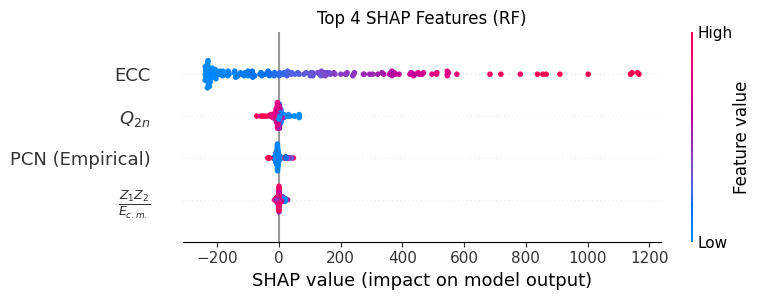

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Run Random Forest with all three feature sets, no ensemble, and with publication-quality plot aesthetics
rf_results = run_model_conference(
    model_class=RandomForestRegressor,
    model_params={
        "random_state": 42,
        "n_estimators": 100,
    },
    X_train_basic=X_train_basic, y_train_basic=y_train_basic, # Include Basic data
    X_train_basic_ecc=X_train_basic_ecc, y_train_basic_ecc=y_train_basic_ecc, # Include Basic+ECC data
    X_train_phys=X_train_phys, # Use the REDUCED physics features
    y_train_phys=y_train_phys,
    X_test_basic=X_test_basic, # Include Basic test data
    X_test_basic_ecc=X_test_basic_ecc, # Include Basic+ECC test data
    X_test_phys=X_test_phys, # Use the REDUCED physics features
    TECC_csv=TECC_csv,
    test_idx=test_idx,
    model_label="RF",
    run_shap=True, # Keep SHAP analysis enabled
    use_ensemble=False, # Do not use ensemble

    show_grid=False # Set to False to remove grids
)


--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
XGB-ECC,37.4968,0.9820,0.0983
XGB-Pred (Basic),162.8667,0.6123,0.4868
XGB-Pred (Basic+ECC),41.6024,0.9797,0.3048
XGB-Pred (Physics),41.9813,0.9775,0.2802


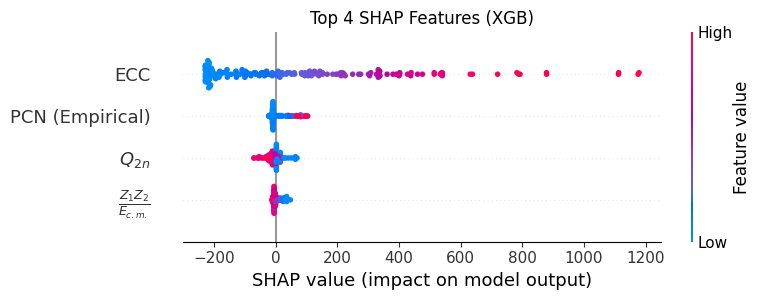

In [ ]:
from xgboost import XGBRegressor

# Run XGBoost with all three feature sets, no ensemble, publication-quality plots
xgb_results = run_model_conference(
    model_class=XGBRegressor,
    model_params={
        "random_state": 42,
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 5,
        "objective": "reg:squarederror"
    },
    X_train_basic=X_train_basic,
    y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc,
    y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys,
    y_train_phys=y_train_phys,
    X_test_basic=X_test_basic,
    X_test_basic_ecc=X_test_basic_ecc,
    X_test_phys=X_test_phys,
    TECC_csv=TECC_csv,
    test_idx=test_idx,
    model_label="XGB",
    run_shap=True,        # Enable SHAP analysis
    use_ensemble=False,   # No stacking ensemble
              # Use colored lines
    show_grid=True        # Show grid for easier reading
)



--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
GBR-ECC,37.4968,0.9820,0.0983
GBR-Pred (Basic),113.8469,0.8121,0.4225
GBR-Pred (Basic+ECC),43.5726,0.9776,0.4700
GBR-Pred (Physics),39.1998,0.9797,0.2403


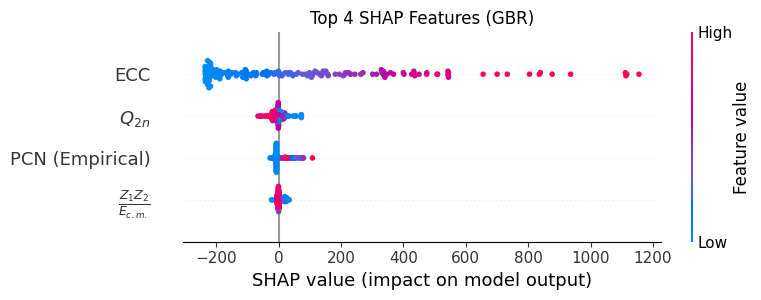

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Run Gradient Boosting with all three feature sets, no ensemble, publication-quality plots
gbr_results = run_model_conference(
    model_class=GradientBoostingRegressor,
    model_params={
        "random_state": 42,
        "n_estimators": 200,
        "learning_rate": 0.05,
        "max_depth": 5,
        "loss": "squared_error" # Using 'squared_error' for regression
    },
    X_train_basic=X_train_basic,
    y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc,
    y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys,
    y_train_phys=y_train_phys,
    X_test_basic=X_test_basic,
    X_test_basic_ecc=X_test_basic_ecc,
    X_test_phys=X_test_phys,
    TECC_csv=TECC_csv,
    test_idx=test_idx,
    model_label="GBR", # Label for Gradient Boosting Regressor
    run_shap=True,        # Enable SHAP analysis
    use_ensemble=False,   # No stacking ensemble
    show_grid=True        # Show grid for easier reading
)

In [ ]:
!pip install lightgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 3371, number of used features: 10
[LightGBM] [Info] Start training from score 238.911080
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 3371, number of used features: 11
[LightGBM] [Info] Start training from score 238.911080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

,RMSE,R2,log10-MAE
Model,,,
LGBM-ECC,37.4968,0.9820,0.0983
LGBM-Pred (Basic),99.6981,0.8536,0.3907
LGBM-Pred (Basic+ECC),41.3712,0.9803,0.3157
LGBM-Pred (Physics),51.0075,0.9699,0.1754


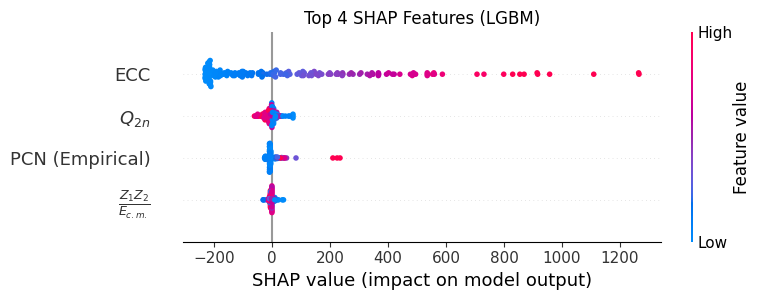

In [ ]:
from lightgbm import LGBMRegressor

# Run LightGBM with all three feature sets, no ensemble, publication-quality plots
lgbm_results = run_model_conference(
    model_class=LGBMRegressor,
    model_params={
        "random_state": 42,
        "n_estimators": 200,
        "learning_rate": 0.05,
        "num_leaves": 31, # Default value
        "objective": "regression",
        "n_jobs": -1 # Use all available cores
    },
    X_train_basic=X_train_basic,
    y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc,
    y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys,
    y_train_phys=y_train_phys,
    X_test_basic=X_test_basic,
    X_test_basic_ecc=X_test_basic_ecc,
    X_test_phys=X_test_phys,
    TECC_csv=TECC_csv,
    test_idx=test_idx,
    model_label="LGBM", # Label for LightGBM Regressor
    run_shap=True,        # Enable SHAP analysis
    use_ensemble=False,   # No stacking ensemble
    show_grid=True        # Show grid for easier reading
)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Re-run models to get the test predictions DataFrame
rf_results_df, rf_predictions_df = run_model_conference(
    model_class=RandomForestRegressor,
    model_params={"random_state": 42, "n_estimators": 100},
    X_train_basic=X_train_basic, y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc, y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys, y_train_phys=y_train_phys,
    X_test_basic=X_test_basic, X_test_basic_ecc=X_test_basic_ecc, X_test_phys=X_test_phys,
    TECC_csv=TECC_csv, test_idx=test_idx,
    model_label="RF", run_shap=False, use_ensemble=False, show_grid=False # SHAP and plots can be disabled for just getting the data
)

xgb_results_df, xgb_predictions_df = run_model_conference(
    model_class=XGBRegressor,
    model_params={"random_state": 42, "n_estimators": 200, "learning_rate": 0.05, "max_depth": 5, "objective": "reg:squarederror"},
    X_train_basic=X_train_basic, y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc, y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys, y_train_phys=y_train_phys,
    X_test_basic=X_test_basic, X_test_basic_ecc=X_test_basic_ecc, X_test_phys=X_test_phys,
    TECC_csv=TECC_csv, test_idx=test_idx,
    model_label="XGB", run_shap=False, use_ensemble=False, show_grid=False
)

gbr_results_df, gbr_predictions_df = run_model_conference(
    model_class=GradientBoostingRegressor,
    model_params={"random_state": 42, "n_estimators": 200, "learning_rate": 0.05, "max_depth": 5, "loss": "squared_error"},
    X_train_basic=X_train_basic, y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc, y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys, y_train_phys=y_train_phys,
    X_test_basic=X_test_basic, X_test_basic_ecc=X_test_basic_ecc, X_test_phys=X_test_phys,
    TECC_csv=TECC_csv, test_idx=test_idx,
    model_label="GBR", run_shap=False, use_ensemble=False, show_grid=False
)

lgbm_results_df, lgbm_predictions_df = run_model_conference(
    model_class=LGBMRegressor,
    model_params={"random_state": 42, "n_estimators": 200, "learning_rate": 0.05, "num_leaves": 31, "objective": "regression", "n_jobs": -1},
    X_train_basic=X_train_basic, y_train_basic=y_train_basic,
    X_train_basic_ecc=X_train_basic_ecc, y_train_basic_ecc=y_train_basic_ecc,
    X_train_phys=X_train_phys, y_train_phys=y_train_phys,
    X_test_basic=X_test_basic, X_test_basic_ecc=X_test_basic_ecc, X_test_phys=X_test_phys,
    TECC_csv=TECC_csv, test_idx=test_idx,
    model_label="LGBM", run_shap=False, use_ensemble=False, show_grid=False
)

# Combine the prediction dataframes
combined_predictions = rf_predictions_df[['Reaction', 'E c.m.', 'σ']].copy()
combined_predictions = combined_predictions.rename(columns={'σ': 'σ_Exp'})

# Merge predictions from each model and feature set
# RF
combined_predictions = combined_predictions.merge(rf_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic']], on=['Reaction', 'E c.m.'], suffixes=('', '_RF_Basic'))
combined_predictions = combined_predictions.merge(rf_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic_ecc']], on=['Reaction', 'E c.m.'], suffixes=('', '_RF_Basic_ECC'))
combined_predictions = combined_predictions.merge(rf_predictions_df[['Reaction', 'E c.m.', 'σ_pred_phys']], on=['Reaction', 'E c.m.'], suffixes=('', '_RF_Physics'))

# XGB
combined_predictions = combined_predictions.merge(xgb_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic']], on=['Reaction', 'E c.m.'], suffixes=('', '_XGB_Basic'))
combined_predictions = combined_predictions.merge(xgb_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic_ecc']], on=['Reaction', 'E c.m.'], suffixes=('', '_XGB_Basic_ECC'))
combined_predictions = combined_predictions.merge(xgb_predictions_df[['Reaction', 'E c.m.', 'σ_pred_phys']], on=['Reaction', 'E c.m.'], suffixes=('', '_XGB_Physics'))

# GBR
combined_predictions = combined_predictions.merge(gbr_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic']], on=['Reaction', 'E c.m.'], suffixes=('', '_GBR_Basic'))
combined_predictions = combined_predictions.merge(gbr_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic_ecc']], on=['Reaction', 'E c.m.'], suffixes=('', '_GBR_Basic_ECC'))
combined_predictions = combined_predictions.merge(gbr_predictions_df[['Reaction', 'E c.m.', 'σ_pred_phys']], on=['Reaction', 'E c.m.'], suffixes=('', '_GBR_Physics'))

# LGBM
combined_predictions = combined_predictions.merge(lgbm_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic']], on=['Reaction', 'E c.m.'], suffixes=('', '_LGBM_Basic'))
combined_predictions = combined_predictions.merge(lgbm_predictions_df[['Reaction', 'E c.m.', 'σ_pred_basic_ecc']], on=['Reaction', 'E c.m.'], suffixes=('', '_LGBM_Basic_ECC'))
combined_predictions = combined_predictions.merge(lgbm_predictions_df[['Reaction', 'E c.m.', 'σ_pred_phys']], on=['Reaction', 'E c.m.'], suffixes=('', '_LGBM_Physics'))


# Add ECC values for comparison
combined_predictions['σ_ECC'] = rf_predictions_df['ECC'] # ECC is the same for all models/feature sets

# Display the combined table
display(combined_predictions)


--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
RF-ECC,37.4968,0.9820,0.0983
RF-Pred (Basic),106.9582,0.8227,0.3183
RF-Pred (Basic+ECC),40.9631,0.9807,0.0854
RF-Pred (Physics),45.5353,0.9750,0.0856



--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
XGB-ECC,37.4968,0.9820,0.0983
XGB-Pred (Basic),162.8667,0.6123,0.4868
XGB-Pred (Basic+ECC),41.6024,0.9797,0.3048
XGB-Pred (Physics),41.9813,0.9775,0.2802



--- Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
GBR-ECC,37.4968,0.9820,0.0983
GBR-Pred (Basic),113.8469,0.8121,0.4225
GBR-Pred (Basic+ECC),43.5726,0.9776,0.4700
GBR-Pred (Physics),39.1998,0.9797,0.2403


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 733
[LightGBM] [Info] Number of data points in the train set: 3371, number of used features: 10
[LightGBM] [Info] Start training from score 238.911080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 988
[LightGBM] [Info] Number of data points in the train set: 3371, number of used features: 11
[LightGBM] [Info] Start training from score 238.911080
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set:

,RMSE,R2,log10-MAE
Model,,,
LGBM-ECC,37.4968,0.9820,0.0983
LGBM-Pred (Basic),99.6981,0.8536,0.3907
LGBM-Pred (Basic+ECC),41.3712,0.9803,0.3157
LGBM-Pred (Physics),51.0075,0.9699,0.1754


,Reaction,E c.m.,σ_Exp,σ_pred_basic,σ_pred_basic_ecc,σ_pred_phys,σ_pred_basic_XGB_Basic,σ_pred_basic_ecc_XGB_Basic_ECC,σ_pred_phys_XGB_Physics,σ_pred_basic_GBR_Basic,σ_pred_basic_ecc_GBR_Basic_ECC,σ_pred_phys_GBR_Physics,σ_pred_basic_LGBM_Basic,σ_pred_basic_ecc_LGBM_Basic_ECC,σ_pred_phys_LGBM_Physics,σ_ECC
0,16 O + 70 Ge,31.300,0.360,1.3114,0.7409,1.4866,5.4025,-5.6300,-0.1025,8.7959,-3.0520,0.2225,-13.0083,-4.1279,1.3555,NaN
1,16 O + 70 Ge,32.100,1.630,2.7240,2.2723,2.7272,59.1159,-2.4933,2.3110,15.3143,-1.0723,2.5332,-3.8926,-3.0677,3.9377,NaN
2,16 O + 70 Ge,33.000,6.840,18.2724,7.8002,8.7592,59.1159,4.1911,8.4796,54.0200,5.5387,9.0604,6.5077,3.3817,10.5646,NaN
3,16 O + 70 Ge,33.800,19.980,21.9918,20.9611,21.9693,62.1604,15.5335,20.1246,54.0200,17.5430,21.1061,6.5077,14.4736,21.6181,NaN
4,16 O + 70 Ge,34.600,46.600,47.2525,43.2679,38.4873,114.3316,37.6068,43.0663,102.7132,37.6512,44.3373,54.1178,36.6333,46.4367,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1619050,40 Ca + 50 Ti,73.608,648.613,623.9020,625.2412,557.2659,479.0363,631.3206,567.9528,522.4503,626.7742,562.3043,537.6265,655.2327,528.5112,NaN
1619051,40 Ca + 50 Ti,75.824,730.619,670.5556,680.0253,613.6465,511.1000,657.0074,582.7315,564.4606,678.1961,615.6819,537.1225,672.7088,532.7605,NaN
1619052,40 Ca + 50 Ti,78.041,748.226,730.4102,719.5536,653.8623,549.2903,720.8918,625.1103,616.1445,745.1213,589.5372,606.2872,751.7229,585.2944,NaN
1619053,40 Ca + 50 Ti,80.345,766.257,697.4028,690.7355,671.0749,586.4388,738.6102,635.0950,632.9814,749.5674,629.9384,605.2024,748.2982,612.7258,NaN


In [ ]:
# Combine the results DataFrames
combined_results = pd.concat([rf_results_df, xgb_results_df, gbr_results_df, lgbm_results_df], ignore_index=True)

# Display the combined evaluation metrics table
print("--- Combined Mean Evaluation Metrics Across All Test Reactions ---")
display(combined_results.groupby('Model')[['RMSE','R2','log10-MAE']].mean())

--- Combined Mean Evaluation Metrics Across All Test Reactions ---


,RMSE,R2,log10-MAE
Model,,,
GBR-ECC,56.7532,0.9655,0.1399
GBR-Pred (Basic),112.9946,0.8907,0.5742
GBR-Pred (Basic+ECC),41.7781,0.9795,0.5623
GBR-Pred (Physics),42.5972,0.9636,0.2137
LGBM-ECC,56.7532,0.9655,0.1399
LGBM-Pred (Basic),107.6898,0.9021,0.4723
LGBM-Pred (Basic+ECC),46.3032,0.9825,0.2724
LGBM-Pred (Physics),46.8595,0.9618,0.3303
RF-ECC,56.7532,0.9655,0.1399


In [ ]:
# Reshape the combined_results DataFrame for a more systematic table
systematic_results = combined_results.pivot_table(
    index='Model', # Keep the combined model and feature set as index for now
    values=['RMSE', 'R2', 'log10-MAE'],
    aggfunc='mean' # Aggregate by mean since the combined_results already contains per-reaction metrics
)

# Split the 'Model' index into 'Model' and 'Feature Set'
systematic_results[['Model_Name', 'Feature_Set']] = systematic_results.index.str.split('-', expand=True)

# Create a new index using only the Model Name
systematic_results = systematic_results.set_index('Model_Name')

# Rename columns for clarity in the final pivoted table
systematic_results = systematic_results.rename(columns={
    'RMSE': 'RMSE', 'R2': 'R2', 'log10-MAE': 'log10-MAE'
})

# Further pivot the table to have Feature Sets as columns and Model Names as index
final_paper_table = systematic_results.pivot_table(
    index='Model_Name',
    columns='Feature_Set',
    values=['RMSE', 'R2', 'log10-MAE']
)

# Reorder the columns to group metrics by feature set (e.g., Basic_RMSE, Basic_R2, etc.)
# Get the unique feature sets in the desired order
feature_sets_order = ['Pred (Basic)', 'Pred (Basic+ECC)', 'Pred (Physics)', 'ECC']
metrics_order = ['RMSE', 'R2', 'log10-MAE']

ordered_columns = []
for fs in feature_sets_order:
    for metric in metrics_order:
        # Handle cases where a combination might not exist (though in this case it should)
        col_name = (metric, fs)
        if col_name in final_paper_table.columns:
             ordered_columns.append(col_name)

final_paper_table = final_paper_table[ordered_columns]


# Rename the columns for the final output (removing the multi-level index)
final_paper_table.columns = [f'{metric}_{fs.replace("Pred (", "").replace(")", "").strip()}' for metric, fs in final_paper_table.columns]

# Rename the index for clarity
final_paper_table.index.name = 'Model'

# Display the systematic table
print("\n--- Systematic Evaluation Metrics Table for Paper ---")
display(final_paper_table)

ValueError: Columns must be same length as key

In [ ]:
# Select the relevant columns (metrics for Basic+ECC and Physics feature sets)
best_models_table = final_paper_table[[
    'RMSE_Basic+ECC', 'R2_Basic+ECC', 'log10-MAE_Basic+ECC',
    'RMSE_Physics', 'R2_Physics', 'log10-MAE_Physics'
]].copy()

# Rename columns for brevity
best_models_table.columns = [
    'RMSE_B+ECC', 'R2_B+ECC', 'MAE_B+ECC',
    'RMSE_Phys', 'R2_Phys', 'MAE_Phys'
]

# Rename index (model names) for brevity
best_models_table.index = best_models_table.index.str.replace('Pred \\(', '').str.replace('\\)', '') # Remove "Pred (" and ")" if present, although the current index is just the model name

# If the index still has "RF", "XGB", "GBR", "LGBM", keep them as is or rename further if needed
# For example, to rename 'RF' to 'Random Forest', 'XGB' to 'XGBoost', etc.
# best_models_table.rename(index={'RF': 'RandomForest', 'XGB': 'XGBoost', 'GBR': 'GBoost', 'LGBM': 'LightGBM'}, inplace=True)


# Display the simplified table
print("\n--- Comparison of Models on Basic+ECC and Physics Feature Sets ---")
display(best_models_table)


--- Comparison of Models on Basic+ECC and Physics Feature Sets ---


,RMSE_B+ECC,R2_B+ECC,MAE_B+ECC,RMSE_Phys,R2_Phys,MAE_Phys
Model,,,,,,
GBR,40.0413,0.9798,0.3385,46.0540,0.9582,0.2386
LGBM,46.7547,0.9782,0.2678,66.1635,0.9569,0.1729
RF,39.5556,0.9794,0.1310,43.3888,0.9639,0.1486
XGB,45.6288,0.9775,0.3358,53.2069,0.9580,0.2958
